**Authenticate and mount network directory between colab and google drive**

In [1]:
from google.colab import auth
auth.authenticate_user

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Check 'data' directory in google drive**

In [2]:
!cd "/content/drive/My Drive/data"; ls -l

total 329893
-rw------- 1 root root 337809843 Nov 11  2017 mercari_train.tsv


**Check other environemnent settings**

In [3]:
!cat /proc/meminfo;cat /proc/cpuinfo

MemTotal:       13333552 kB
MemFree:        10773548 kB
MemAvailable:   12518848 kB
Buffers:           74756 kB
Cached:          1821704 kB
SwapCached:            0 kB
Active:           679764 kB
Inactive:        1617784 kB
Active(anon):     372764 kB
Inactive(anon):      336 kB
Active(file):     307000 kB
Inactive(file):  1617448 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              4660 kB
Writeback:             0 kB
AnonPages:        401124 kB
Mapped:           204792 kB
Shmem:               932 kB
Slab:             160144 kB
SReclaimable:     123388 kB
SUnreclaim:        36756 kB
KernelStack:        4288 kB
PageTables:         5432 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2797212 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              928 kB
AnonHugePages:   

###Data Preprocessing

In [4]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv("/content/drive/My Drive/data/mercari_train.tsv", sep="\t")
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...




*   train_id : data id
*   name : product name
*   item_condition_id : condition of product
*   category_name : name of the category
*   brand_name : brand name
*   price = product price **(target)**
*   shipping = boolean for shipping price (1 for free, 0 for charge)
*   item_description = explanation on product



In [5]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


**Check distribution of the target**

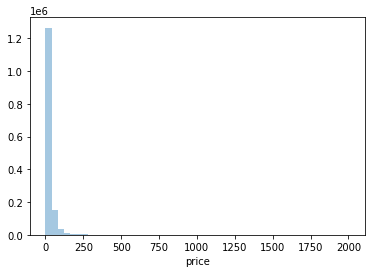

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

**log transformation on target price**

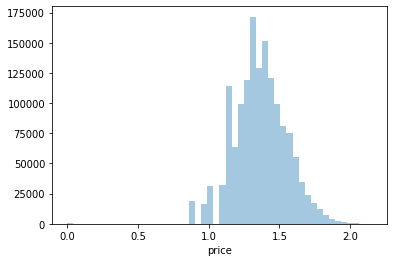

In [9]:
import numpy as np
y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [10]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

**Get chracteristic of each features**

In [11]:
print("Shipping price type: \n", mercari_df['shipping'].value_counts())
print('item_condition_id type: \n', mercari_df['item_condition_id'].value_counts())

Shipping price type: 
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id type: 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [12]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [13]:
# seperate the category values, and creat seperate columns

def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# use split_cat function to creat new columns
# * added to return tuple
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# check if everything worked fine
print(mercari_df['cat_dae'].value_counts())
print(mercari_df['cat_jung'].nunique())
print(mercari_df['cat_so'].nunique())


Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
114
871


**fill in null values**

In [14]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

mercari_df.isnull().sum()


train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [15]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1482535 non-null  object 
 4   brand_name         1482535 non-null  object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482535 non-null  object 
 8   cat_dae            1482535 non-null  object 
 9   cat_jung           1482535 non-null  object 
 10  cat_so             1482535 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


### Feature encoding and vectorization

**check brand name and name**

In [16]:
print('brand name unique counts:', mercari_df['brand_name'].nunique())
print('brand names sample: \n', mercari_df['brand_name'].value_counts()[:5])

brand name unique counts: 4810
brand names sample: 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [17]:
print('name unique counts:', mercari_df['name'].nunique())
print('names sample: \n', mercari_df['name'].value_counts()[:5])

name unique counts: 1225273
names sample: 
 Bundle      2232
Reserved     453
Converse     445
BUNDLE       418
Dress        410
Name: name, dtype: int64


**Check item_description**

In [18]:
pd.set_option('max_colwidth', 200)

# item_description's average length
print("average length of item_description:", mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

average length of item_description: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [19]:
# garbage collector
import gc
gc.collect()

202

**convert 'name' with countvectorizer, 'item_description' with TF_IDF**

In [20]:
cnt_vect = CountVectorizer(max_features=30000)
X_name = cnt_vect.fit_transform(mercari_df['name'])

tfidf_vect = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_vect.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)


name vectorization shape: (1482535, 30000)
item_description vectorization shape: (1482535, 50000)


In [23]:
tfidf_vect.get_feature_names()[:10]

['00',
 '00 00',
 '00 advantage',
 '00 advantage kindness',
 '00 bundles',
 '00 bundles 45',
 '00 buy',
 '00 buy pair',
 '00 free',
 '00 free shipping']

**use sklearn's LabelBinarizer to one-hot encode and save as sprase matrix**

In [26]:
from sklearn.preprocessing import LabelBinarizer

lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [27]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print("X_brand_shape : {0}, X_item_cond_id shape: {1}".format(X_brand.shape, X_item_cond_id.shape))
print("X_shipping_shape : {0}, X_cat_dae shape: {1}".format(X_shipping.shape, X_cat_dae.shape))
print("X_brand_shape : {0}, X_item_cond_id shape: {1}".format(X_cat_jung.shape, X_cat_so.shape))


<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape : (1482535, 4810), X_item_cond_id shape: (1482535, 5)
X_shipping_shape : (1482535, 1), X_cat_dae shape: (1482535, 11)
X_brand_shape : (1482535, 114), X_item_cond_id shape: (1482535, 871)


In [28]:
import gc
gc.collect()

467

**combine feature vectorized sparse matrix and one-hot encoded sparse matrix using hsktask()**

In [29]:
# hstack = horizontal stacking
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# use scipy hstack to combine all data
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 85812)


640

### Use Ridge Regression model to evaluate

**define rmsle**

In [33]:
def rmsle(y, y_pred):
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

  # re-convert predicted data since it was log transformed
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

**Create model_train_predict() function for perform evaluation on multiple models**

In [31]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

**Perform evaluation on Ridge**

In [34]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description excluded, rmsle:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description included, rmsle:', evaluate_org_price(y_test, linear_preds))


Item Description excluded, rmsle: 0.5027973690574066
Item Description included, rmsle: 0.47114366040632394


In [35]:
import gc
gc.collect()

0

**Use LightGBM regression model to evaluate**

In [36]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LGBM rmsle:', evaluate_org_price(y_test, lgbm_preds))

LGBM rmsle: 0.4569096300487453


In [37]:
preds = lgbm_preds *0.45 + linear_preds*0.55
print('LGBM and Ridge ensemble rmsle:', evaluate_org_price(y_test, preds))

LGBM and Ridge ensemble rmsle: 0.45059234446789687
